# Phydra v1.0
### a flexible object-oriented framework for building and ordinary differential equation (ODE)-based models in python

In [1]:
import numpy as np
import xsimlab as xs

import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

## the very basics

the basic component of a phydra model is a *python class* decorated with phydra.comp()

In [2]:
@phydra.comp()
class ModelComponent:
    pass

the decorator parses the user supplied class into a functional xsimlab process

this can be visualised using the process_info function

In [3]:
xs.process_info(ModelComponent)

<ModelComponent  (xsimlab process)>
Variables:
    m              [in] <--- Backend.m
    label         [out]
    firstinit      [in] <--- group 'FirstInit'
    secondinit     [in] <--- group 'SecondInit'
    group         [out]
Simulation stages:
    initialize


as you can see, it already comes with a few generic variables, that are important for the *phydra component* to be functional in the model backend

# creating meaningful components

## the user can choose from 3 built in variable types:
- phydra.variable()
- phydra.forcing()
- phydra.parameter()

this can be easily extended in the future, to allow for more complex use cases

### let's create another component

In [4]:
@phydra.comp(init_stage=2)
class VariableComp:
    var = phydra.variable(description='a generic variable')

let's look under the hood:

In [5]:
xs.process_info(VariableComp)

<VariableComp  (xsimlab process)>
Variables:
    m             [in] <--- Backend.m
    label        [out]
    firstinit     [in] <--- group 'FirstInit'
    group        [out]
    var_label     [in] label / a generic variable
    var_init      [in] initial value / a generic variable
    var_value    [out] ('time',) output of variable value / a gener...
Simulation stages:
    initialize


a phydra.variable automatically generates 3 new variables in the resulting xsimlab process:
### a local variable needs
    - the user-supplied label
    - the user-supplied initial value
    - and the output value, that stores the value after the model is solved

### it is also possible to reference a variable created in another component

In [6]:
@phydra.comp()
class ForeignVariableComp:
    var = phydra.variable(foreign=True, description='a generic variable')

In [7]:
xs.process_info(ForeignVariableComp)

<ForeignVariableComp  (xsimlab process)>
Variables:
    m              [in] <--- Backend.m
    label         [out]
    firstinit      [in] <--- group 'FirstInit'
    secondinit     [in] <--- group 'SecondInit'
    group         [out]
    var            [in] label reference / a generic variable
Simulation stages:
    initialize


### as you can see, only a single xsimlab variable is created, 

which is the label to reference the variable in the model backend

# but a model needs functions right?

## yes, exactly, in Phydra these are called fluxes

fluxes are given as functions supplied with the class,

each flux is registered with one or multiple variables like so:

In [8]:
@phydra.comp
class ForeignVariableFluxComp:
    var = phydra.variable(foreign=True, flux='increase', description='a generic variable')
    
    @phydra.flux
    def increase(self, var):
        return 0.1

In [9]:
xs.process_info(ForeignVariableFluxComp)

<ForeignVariableFluxComp  (xsimlab process)>
Variables:
    m                  [in] <--- Backend.m
    label             [out]
    firstinit          [in] <--- group 'FirstInit'
    secondinit         [in] <--- group 'SecondInit'
    group             [out]
    var                [in] label reference / a generic variable
    increase_value    [out] ('time',) output of flux value / 
Simulation stages:
    initialize


## as you can see, the component automatically stores the value of the flux

## now let's build our very first model:

### the components:
- VariableComp (creates the variable in the model backend)
- ForeignVariableFluxComp (creates a flux acting on the variable in the model backend)

# we create a model using the function phydra.create()

In [10]:
FirstModel = phydra.create({'X':VariableComp, 'Flux':ForeignVariableFluxComp})

## it returns a fully functional xsimlab model object_

In [11]:
FirstModel

<xsimlab.Model (5 processes, 5 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) sequence of time points fo...
X
    var_label       [in] label / a generic variable
    var_init        [in] initial value / a generic variable
Flux
    var             [in] label reference / a generic variable
Solver

# we supply solver, time and parameters to this model using phydra.setup()

In [12]:
FirstModelSetup = phydra.setup('odeint', FirstModel,
            time=np.arange(0,10),
            input_vars={
                'X':{'var_label':'X', 'var_init':1.},
                'Flux':{'var':'X'},
                
            },
            output_vars="ALL"
            )

## which returns an xarray.Dataset containing all supplied values & labels

In [13]:
FirstModelSetup

<xarray.Dataset>
Dimensions:            (clock: 2, input_time: 10)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: input_time
Data variables:
    X__var_label       <U1 'X'
    X__var_init        float64 1.0
    Flux__var          <U1 'X'
    Core__solver_type  <U6 'odeint'
    Time__time         (input_time) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    __xsimlab_output_vars__:  X__var_value,Flux__increase_value

# now we can simply run this model, like so:

In [14]:
a = [[0.0685648,  0.07248796, 0.07660485, 0.05978384, 0.05981344, 0.05984305],
 [0.07014415, 0.07420252, 0.07846538, 0.04373727, 0.04374189, 0.0437465 ],
 [0.07179966, 0.07600544, 0.08042778, 0.03484381, 0.03483684, 0.03482986],
 [0.07353697, 0.07790367, 0.08250052, 0.03078063, 0.03076822, 0.0307558 ],
 [0.07536229, 0.07990495, 0.08469304, 0.03087758, 0.03086275, 0.03084793]]
b = [[1.0685648 ],
 [0.07014415],
 [0.07179966],
 [0.07353697],
 [0.07536229]]
a = np.array(a)
b = np.array(b)

In [15]:
a[0]

array([0.0685648 , 0.07248796, 0.07660485, 0.05978384, 0.05981344,
       0.05984305])

In [16]:
print(a.ndim)
print(b.ndim)

2
2


In [17]:
np.column_stack([b,a])

array([[1.0685648 , 0.0685648 , 0.07248796, 0.07660485, 0.05978384,
        0.05981344, 0.05984305],
       [0.07014415, 0.07014415, 0.07420252, 0.07846538, 0.04373727,
        0.04374189, 0.0437465 ],
       [0.07179966, 0.07179966, 0.07600544, 0.08042778, 0.03484381,
        0.03483684, 0.03482986],
       [0.07353697, 0.07353697, 0.07790367, 0.08250052, 0.03078063,
        0.03076822, 0.0307558 ],
       [0.07536229, 0.07536229, 0.07990495, 0.08469304, 0.03087758,
        0.03086275, 0.03084793]])

In [18]:
with FirstModel:
    output = FirstModelSetup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component X
Initializing component Flux
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x15609c1c0>
Model is assembled:
Model contains: 
Variables:['time', 'X'] 
Parameters:[] 
Forcings:[] 
Fluxes:['Time_time_flux', 'Flux_increase'] 
Full Model Dimensions:[('time', None), ('X', None), ('Time_time_flux', None), ('Flux_increase', None)] 

finalizing: cleanup
Model was solved in 0.0037 seconds


# let's check the output:

In [19]:
output

<xarray.Dataset>
Dimensions:               (clock: 2, input_time: 10, time: 10)
Coordinates:
  * clock                 (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type     <U6 'odeint'
    Flux__increase_value  (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
    Flux__var             <U1 'X'
    Time__time            (input_time) int64 0 1 2 3 4 5 6 7 8 9
    X__var_init           float64 1.0
    X__var_label          <U1 'X'
    X__var_value          (time) float64 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9

In [20]:
import matplotlib.pyplot as plt

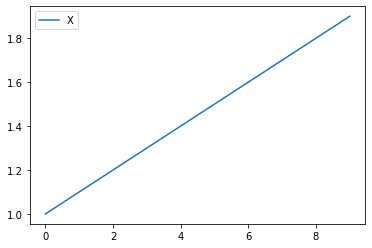

In [21]:
time = output.Time__time

plt.plot(time, output.X__var_value, label='X')
plt.legend()

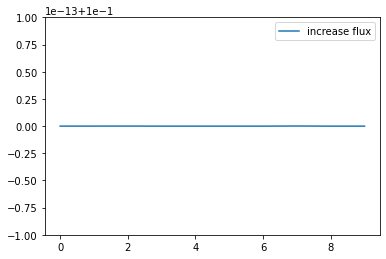

In [22]:
plt.plot(time, output.Flux__increase_value, label='increase flux')
plt.legend()

# NOW let's try a more complex model, a simple marine ecosystem model

In [23]:
from phydra.components.variables import SV

In [24]:
from phydra.components.fluxes.basic import LinearExchange, LinearDecay
from phydra.components.fluxes.basic_forcing import LinearForcingInput
from phydra.components.fluxes.growth import MonodGrowth
# from phydra.components.forcings import ConstantForcing

### this is how forcing works:

In [25]:
@phydra.comp(init_stage=2)
class ConstantForcing:
    forcing = phydra.forcing(foreign=False, file_input_func='forcing_setup')
    value = phydra.parameter(description='constant value of forcing')

    def forcing_setup(self, value):

        @np.vectorize
        def forcing(time):
            return value

        return forcing

## create the model from prebuilt components:

In [26]:
NPZD = phydra.create({'Nutrient':SV,
                      'Phytoplankton':SV,

                      'Input':LinearForcingInput, 
                      'Growth': MonodGrowth,
                      'Mortality': LinearDecay,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':ConstantForcing
                     })

In [27]:
NPZD

<xsimlab.Model (9 processes, 16 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Phytoplankton
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
N0
    forcing_label     [in] label / 
    value             [in] constant value of forcing
Input
    forcing           [in] label reference / forcing affecting flux
    var               [in] label reference / variable affected by flux
    rate              [in] linear rate of change
Growth
    resource          [in] label reference / 
    halfsat           [in] half-saturation constant
    consumer          [in] label reference / 
Mortality
    var               [in] label reference / variable affected by flux
    rate              [in] linear rate of decay/mortality
Solver

In [28]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,100,0.1),
            input_vars={
                'Nutrient':{'var_label':'N', 'var_init':3.},
                'Phytoplankton':{'var_label':'P', 'var_init':0.1},
                
                'Input':{'var':'N', 'rate':0.1, 'forcing':'N0'},
                
                'Growth':{'consumer':'P', 'resource':'N', 'halfsat':1.5},
                
                'Mortality':{'var':'P', 'rate':0.1},
                
                'N0':{'forcing_label':'N0', 'value':2.}
            },
            output_vars="ALL"
            )

In [29]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component N0
Initializing component Input
Initializing component Growth
Initializing component Mortality
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x1572da730>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P'] 
Parameters:['N0_value', 'Input_rate', 'Growth_halfsat', 'Mortality_rate'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Growth_uptake', 'Mortality_decay'] 
Full Model Dimensions:[('time', None), ('N', None), ('P', None), ('Time_time_flux', None), ('Input_input', None), ('Growth_uptake', None), ('Mortality_decay', None)] 

finalizing: cleanup
Model was solved in 0.07644 seconds


In [30]:
odeint_out

<xarray.Dataset>
Dimensions:                   (clock: 2, input_time: 1000, time: 1000)
Coordinates:
  * clock                     (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type         <U6 'odeint'
    Growth__consumer          <U1 'P'
    Growth__halfsat           float64 1.5
    Growth__resource          <U1 'N'
    Growth__uptake_value      (time) float64 0.06864 0.06864 0.07276 ... 0.2 0.2
    Input__forcing            <U2 'N0'
    Input__input_value        (time) float64 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2
    Input__rate               float64 0.1
    Input__var                <U1 'N'
    Mortality__decay_value    (time) float64 0.01029 0.01029 0.01089 ... 0.2 0.2
    Mortality__rate           float64 0.1
    Mortality__var            <U1 'P'
    N0__forcing_label         <U2 'N0'
    N0__forcing_value         (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    N0__value                 float64 2.0
    Nutrient__var_init        float64 3.0
    Nutrient__var_label       <U1 'N'
    Nutrient__var_value       (time) float64 3.0 3.013 3.026 ... 0.1667 0.1667
    Phytoplankton__var_init   float64 0.1
    Phytoplankton__var_label  <U1 'P'
    Phytoplankton__var_value  (time) float64 0.1 0.1058 0.112 ... 2.0 2.0 2.0
    Time__time                (input_time) float64 0.0 0.1 0.2 ... 99.8 99.9

In [31]:
import matplotlib.pyplot as plt

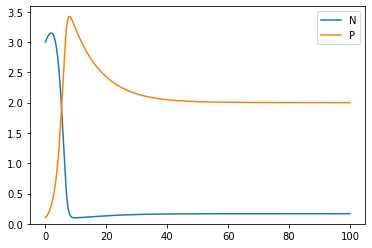

In [32]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

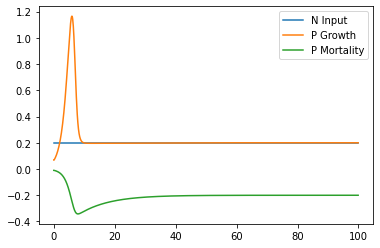

In [33]:
plt.plot(time, odeint_out.Input__input_value, label='N Input')
plt.plot(time, odeint_out.Growth__uptake_value, label='P Growth')
plt.plot(time, -odeint_out.Mortality__decay_value, label='P Mortality')
plt.legend()

# NOW lets check the vectorization capabilities:

In [34]:
from phydra.components.variables import SV, SVArray
from phydra.components.fluxes.basic_dims import LinearDecay_Dims
from phydra.components.fluxes.growth import MonodGrowth_ConsumerDim

In [35]:
NPxZD = phydra.create({'Nutrient':SV,
                      'Phytoplankton':SVArray,

                      'Input':LinearForcingInput, 
                      'Growth': MonodGrowth_ConsumerDim,
                      'Mortality': LinearDecay_Dims,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':ConstantForcing
                     })

In [36]:
NPxZD

<xsimlab.Model (9 processes, 16 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Phytoplankton
    var_init          [in] ('var',) initial value / basic state var...
    var_label         [in] label / basic state variable
N0
    forcing_label     [in] label / 
    value             [in] constant value of forcing
Input
    forcing           [in] label reference / forcing affecting flux
    var               [in] label reference / variable affected by flux
    rate              [in] linear rate of change
Growth
    resource          [in] label reference / 
    halfsat           [in] ('var',) half-saturation constant
    consumer          [in] label reference / 
Mortality
    var               [in] label reference / variable affected by flux
    rate              [in] ('var',) linear rate of dec

In [37]:
odeint_setup = phydra.setup('odeint', NPxZD,
            time=np.arange(0,100,0.1),
            input_vars={
                'Nutrient':{'var_label':'N', 'var_init':3.},
                'Phytoplankton':{'var_label':'P', 'var_init':[0.1, 0.1, 0.1, 0.1, 0.1]},
                
                'Input':{'var':'N', 'rate':0.1, 'forcing':'N0'},
                
                'Growth':{'consumer':'P', 'resource':'N', 'halfsat':[1.5, 1.4, 1.3, 1.2, 1.1]},
                
                'Mortality':{'var':'P', 'rate':[0.09, 0.1, 0.11, 0.12, 0.13]},
                
                'N0':{'forcing_label':'N0', 'value':2.}
            },
            output_vars="ALL"
            )

In [38]:
with NPxZD:
    odeint_out2 = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component N0
Initializing component Input
Initializing component Growth
Initializing component Mortality
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x15750a1c0>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P'] 
Parameters:['N0_value', 'Input_rate', 'Growth_halfsat', 'Mortality_rate'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Growth_uptake', 'Mortality_decay'] 
Full Model Dimensions:[('time', None), ('N', None), ('P', 5), ('Time_time_flux', None), ('Input_input', None), ('Growth_uptake', 5), ('Mortality_decay', 5)] 

finalizing: cleanup
Model was solved in 0.07233 seconds


In [39]:
odeint_out2

<xarray.Dataset>
Dimensions:                   (clock: 2, input_time: 1000, time: 1000, var: 5)
Coordinates:
  * clock                     (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, time, var
Data variables:
    Core__solver_type         <U6 'odeint'
    Growth__consumer          <U1 'P'
    Growth__halfsat           (var) float64 1.5 1.4 1.3 1.2 1.1
    Growth__resource          <U1 'N'
    Growth__uptake_value      (var, time) float64 0.06856 0.06856 ... 0.03085
    Input__forcing            <U2 'N0'
    Input__input_value        (time) float64 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2
    Input__rate               float64 0.1
    Input__var                <U1 'N'
    Mortality__decay_value    (var, time) float64 0.009264 0.009264 ... 0.032
    Mortality__rate           (var) float64 0.09 0.1 0.11 0.12 0.13
    Mortality__var            <U1 'P'
    N0__forcing_label         <U2 'N0'
    N0__forcing_value         (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    N0__value                 float64 2.0
    Nutrient__var_init        float64 3.0
    Nutrient__var_label       <U1 'N'
    Nutrient__var_value       (time) float64 3.0 2.984 2.966 ... 0.1576 0.1576
    Phytoplankton__var_init   (var) float64 0.1 0.1 0.1 0.1 0.1
    Phytoplankton__var_label  <U1 'P'
    Phytoplankton__var_value  (var, time) float64 0.1 0.1059 ... 0.2462 0.2461
    Time__time                (input_time) float64 0.0 0.1 0.2 ... 99.8 99.9

In [40]:
import matplotlib.pyplot as plt

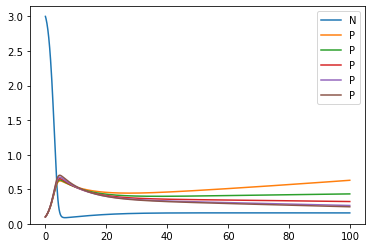

In [41]:
time = odeint_out2.Time__time

plt.plot(time, odeint_out2.Nutrient__var_value, label='N')
plt.plot(time, odeint_out2.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

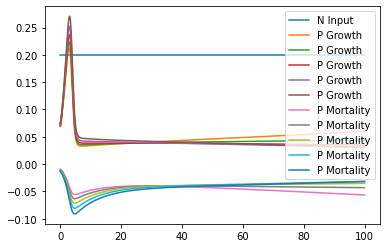

In [42]:
plt.plot(time, odeint_out2.Input__input_value, label='N Input')
plt.plot(time, odeint_out2.Growth__uptake_value.T, label='P Growth')
plt.plot(time, -odeint_out2.Mortality__decay_value.T, label='P Mortality')
plt.legend()